Audio file downloaded and saved to: processed_audio.wav
Loaded processed audio file.
Original Sample Rate: 44100
Resampled Sample Rate: 16000
Duration: 850.83 seconds


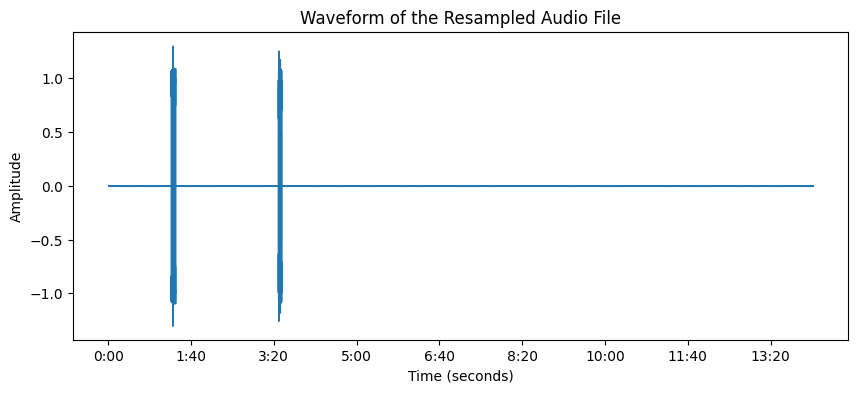

MFCC features saved to ../data/tartanaviation/processed/processed_audio_mfcc.csv


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Import required libraries
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

# Download and save the audio file locally
def download_audio(url, save_path):
    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"Audio file downloaded and saved to: {save_path}")
    except Exception as e:
        print(f"Failed to download audio file: {e}")

processed_audio_url = "https://raw.githubusercontent.com/GitAIwithMike/ATC-Models/main/data/tartanaviation/processed/processed_audio.wav"
local_audio_path = "processed_audio.wav"

download_audio(processed_audio_url, local_audio_path)

# Load processed audio file
def analyze_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=44100)
        resampled_audio = librosa.resample(audio, orig_sr=sr, target_sr=16000)

        print(f"Loaded processed audio file.")
        print(f"Original Sample Rate: {sr}")
        print(f"Resampled Sample Rate: 16000")
        print(f"Duration: {len(audio) / sr:.2f} seconds")

        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(resampled_audio, sr=16000)
        plt.title("Waveform of the Resampled Audio File")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude")
        plt.show()
    except Exception as e:
        print(f"Failed to load {audio_path}: {e}")

analyze_audio(local_audio_path)

# Extract MFCC features and save
mfcc_folder = "../data/tartanaviation/processed/"
os.makedirs(mfcc_folder, exist_ok=True)

def extract_mfcc(audio_path, output_folder):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)

        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_delta = librosa.feature.delta(mfccs)
        mfccs_delta2 = librosa.feature.delta(mfccs, order=2)

        combined_mfccs = np.vstack([mfccs, mfccs_delta, mfccs_delta2])

        mfcc_df = pd.DataFrame(combined_mfccs.T)
        output_path = os.path.join(output_folder, "processed_audio_mfcc.csv")
        mfcc_df.to_csv(output_path, index=False)
        print(f"MFCC features saved to {output_path}")
    except Exception as e:
        print(f"Failed to extract MFCC from {audio_path}: {e}")

extract_mfcc(local_audio_path, mfcc_folder)

# Speech-to-text using Wav2Vec2
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

def transcribe_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
        with torch.no_grad():
            logits = model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        return processor.batch_decode(predicted_ids)[0]
    except Exception as e:
        print(f"Failed to transcribe {audio_path}: {e}")
        return ""

transcription = transcribe_audio(local_audio_path)
print(f"Transcription: {transcription}")

# Intent classification
intent_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
intent_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
intent_labels = ["clearance_request", "alert", "weather_request"]

def classify_intent(transcription):
    try:
        inputs = intent_tokenizer(transcription, return_tensors="pt", truncation=True, padding=True)
        outputs = intent_model(**inputs)
        return intent_labels[torch.argmax(outputs.logits, dim=-1).item()]
    except Exception as e:
        print(f"Failed to classify intent for transcription: {e}")
        return "unknown"

intent = classify_intent(transcription)
print(f"Detected Intent: {intent}")

# Suggest action based on intent
def suggest_action(intent, trajectory_data, weather_data):
    if intent == "clearance_request":
        return f"Clearance granted for {trajectory_data['flight_id']}."
    elif intent == "alert":
        return f"Notify authorities about restricted airspace violation by {trajectory_data['flight_id']}!"
    elif intent == "weather_request":
        return f"Weather update: Visibility {weather_data['visibility']}, Wind Speed {weather_data['wind_speed']}!"
    else:
        return "No action required."

trajectory_data = {"flight_id": "ABC123", "altitude": 30000, "heading": 180}
weather_data = {"location": "runway_22", "visibility": "5 miles", "wind_speed": "10 knots"}

action = suggest_action(intent, trajectory_data, weather_data)
print(f"Suggested Action: {action}")